In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle, islice
import weightedcalcs as wc

# This line lets us plot on our ipython notebook
%matplotlib inline

In [2]:
#Load data
df_15 = pd.read_table("proj_data/ss15hpa_1yr.csv", sep=',', low_memory=False)

#preview first 5 records...
df_15.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp71,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80
0,H,26,2,2600,1,42,1000000,1001264,37,1,...,31,37,33,38,12,11,34,36,33,35
1,H,31,2,3403,1,42,1000000,1001264,206,3,...,205,209,56,216,68,224,235,196,369,319
2,H,35,2,3603,1,42,1000000,1001264,30,2,...,54,51,8,38,31,10,31,9,33,10
3,H,44,2,200,1,42,1000000,1001264,47,2,...,53,46,54,74,54,16,39,16,10,43
4,H,52,2,1200,1,42,1000000,1001264,111,3,...,145,219,24,137,106,164,36,99,119,167


In [3]:
df_15.shape

(63762, 235)

In [4]:
print("total columns:", len(df_15.columns))

total columns: 235


In [5]:
df_15['PUMA'].dtype

dtype('int64')

In [6]:
### NOTE PULL IN SMOCP (selected monthly owner costs) -- Note: Use ADJHSG to adjust SMOCP to constant dollars.
### Pull in NP (Number of person records following this housing record) -- I believe this is right one for determining the poverty guideline...
### Pull in TYPE (type of unit) OR BLD (units in strcuture?)

In [6]:
#too many columns! let's do something about it... 
#get relevant columns: SERIALNO, ST, PUMA, ADJHSG, ADJINC, WGTP, NP, TEN (tenure), BLD, BDSP (# bedrooms), RNTP (rent), VACS (vacancy status),
#...HINCP (hh income), SMOCP (selected monthly owner costs), GRNTP (gross rent), GRPIP (gross rent as % of hh inc), 
#... KIT (complete kitchen), OCPIP (selected monthly owner costs as % hh inc), PLM (complete plumbing) 
df_15_s= df_15[['SERIALNO','ST', 'PUMA', 'ADJHSG', 'WGTP', 'NP', 'TEN', 'BLD', 'BDSP', 'RNTP', 'VACS','HINCP','SMOCP','GRNTP', 'GRPIP','OCPIP', 'KIT', 'PLM']]

df_15_s.head()

,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,VACS,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM
0,26,42,2600,1000000,37,1,3.0,2.0,2.0,500.0,NaN,45000.0,NaN,603.0,16.0,NaN,1.0,1.0
1,31,42,3403,1000000,206,3,3.0,2.0,2.0,800.0,NaN,43300.0,NaN,1147.0,32.0,NaN,1.0,1.0
2,35,42,3603,1000000,30,2,1.0,2.0,4.0,NaN,NaN,125000.0,2090.0,NaN,NaN,20.0,1.0,1.0
3,44,42,200,1000000,47,2,2.0,2.0,3.0,NaN,NaN,96200.0,547.0,NaN,NaN,7.0,1.0,1.0
4,52,42,1200,1000000,111,3,3.0,6.0,2.0,1100.0,NaN,20200.0,NaN,1190.0,71.0,NaN,1.0,1.0


In [7]:
##NOTE there are 5031 records where NP == 0. Reasons why no assoc'd person records? VACS column may shed light
len(df_15_s[df_15_s['NP'] == 0].index)

5031

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112e89668>]], dtype=object)

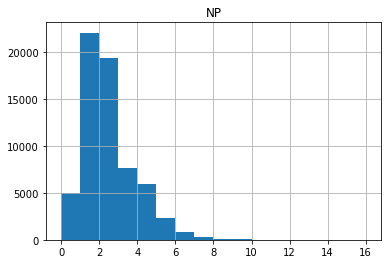

In [8]:
#histogram of distribution of NP (number of person records following this hh)
hh_size = df_15_s.hist(column='NP', bins=16)
hh_size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130378eb8>]], dtype=object)

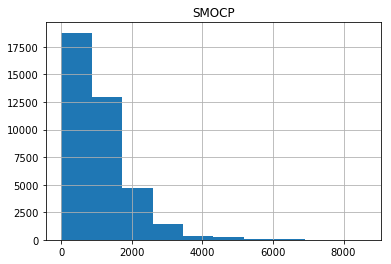

In [9]:
#histogram of distribution of SMOCP 
SMOCP_d = df_15_s.hist(column='SMOCP')
SMOCP_d

In [10]:
#Load poverty guidelines data
pov = pd.read_table("proj_data/pov_guidelines.csv", sep=',', low_memory=False)
pov.head()

,hhd_size,pov_15,pov_14,pov_13,pov_12,pov_11,pov_10,pov_09,pov_08,pov_07,pov_06,pov_05,pov_04,pov_03,pov_02,pov_01,pov_00
0,1,11770.0,11670.0,11490.0,11170.0,10890.00,10830.0,10830.0,10400.0,10210.0,9800.0,9570.0,9310.0,8980.0,8860.0,8590.0,8350.0
1,2,15930.0,15730.0,15510.0,15130.0,"14,710",14570.0,14570.0,14000.0,13690.0,13200.0,12830.0,12490.0,12120.0,11940.0,11610.0,11250.0
2,3,20090.0,19790.0,19530.0,19090.0,"18,530",18310.0,18310.0,17600.0,17170.0,16600.0,16090.0,15670.0,15260.0,15020.0,14630.0,14150.0
3,4,24250.0,23850.0,23550.0,23050.0,"22,350",22050.0,22050.0,21200.0,20650.0,20000.0,19350.0,18850.0,18400.0,18100.0,17650.0,17050.0
4,5,28410.0,27910.0,27570.0,27010.0,"26,170",25790.0,25790.0,24800.0,24130.0,23400.0,22610.0,22030.0,21540.0,21180.0,20670.0,19950.0


In [11]:
#check datatypes to see if join is possible...
print('pov hhd_size:', pov['hhd_size'].dtype, "\n",'pums_np:', df_15_s['NP'].dtype) 


pov hhd_size: int64 
 pums_np: int64


## Merge poverty data to pums

In [12]:
#pull out pov_ 15
pov15=pov.iloc[:,[0,1]]

#merge poverty data to pums
df15_pov = df_15_s.merge(pov15, left_on='NP', right_on='hhd_size')

#let's check that it worked by checking a record, SERIALNO 31
df15_pov[df15_pov['SERIALNO']==31]

,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,VACS,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15
22105,31,42,3403,1000000,206,3,3.0,2.0,2.0,800.0,NaN,43300.0,NaN,1147.0,32.0,NaN,1.0,1.0,3,20090.0


## Filter for RENTER records we want... 

In [13]:
# r is for renters...
df15_r = df15_pov[df15_pov['GRPIP'].notnull()] 
print("PA rental households in data w/ grpip info:", len(df15_r.index))


PA rental households in data w/ grpip info: 11144


In [14]:
#alternatively, can look at data where tenure = rented (TEN: 1=owned w/ mortgage/loan, 2=owned free & clear, 3=rented, 4=occupied w/o rent)
df15_r = df15_pov[df15_pov['TEN']==3] 
print("PA rental households in data where tenure = rented:", len(df15_r.index))


PA rental households in data where tenure = rented: 11388


In [15]:
# renters with complete kitchen and plumbing
df15_rk = df15_r[df15_r['KIT']==1]
df15_rkp = df15_rk[df15_rk['PLM']==1]

print("PA rental households with complete kitchen, plumbing:", len(df15_rkp.index))

PA rental households with complete kitchen, plumbing: 11165


In [16]:
# FILTER for records where hincp is less than poverty guideline
df15r_need = df15_rkp[(df15_rkp['HINCP']<=df15_rkp['pov_15']) & (df15_rkp['GRPIP'].notnull())]

print("PA rental households below fed poverty line:", len(df15r_need.index))

PA rental households below fed poverty line: 2289


## Filter for % of renters in poverty

In [18]:
## create new column that calculates # of renting households below poverty line

# Create a new column called df15r_rkp.WGTPpov where the value is the WGTP if df15r_rkp.HINCP
# is less than or equal to df15r_rkp.pov_15 and 0 if not.
df15_rkp['WGTPpov'] = df15_rkp['WGTP'].where(df15_rkp['HINCP']<=df15_rkp['pov_15'], 0)
df15_rkp.head()

/Users/phoebe/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,...,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15,WGTPpov
0,26,42,2600,1000000,37,1,3.0,2.0,2.0,500.0,...,45000.0,NaN,603.0,16.0,NaN,1.0,1.0,1,11770.0,0
3,208,42,2002,1000000,80,1,3.0,9.0,1.0,290.0,...,14900.0,NaN,360.0,29.0,NaN,1.0,1.0,1,11770.0,0
11,846,42,1701,1000000,74,1,3.0,8.0,1.0,570.0,...,39000.0,NaN,640.0,20.0,NaN,1.0,1.0,1,11770.0,0
13,900,42,2401,1000000,120,1,3.0,6.0,1.0,820.0,...,9170.0,NaN,910.0,101.0,NaN,1.0,1.0,1,11770.0,120
23,1639,42,1100,1000000,72,1,3.0,8.0,1.0,290.0,...,15900.0,NaN,330.0,25.0,NaN,1.0,1.0,1,11770.0,0


In [19]:
# group by PUMA and sum the total hhds (WGTP) and the hhds in poverty (WGTPpov)

#group by PUMA
grp = df15_rkp.groupby(["PUMA"])

#calculate totals by PUMA of hhds and hhds in poverty
df15r_pov = grp[['WGTP','WGTPpov']].sum()
df15r_pov.head()

,WGTP,WGTPpov
PUMA,,
101,20118,7345
102,17091,2970
200,12197,2915
300,15681,3606
400,9454,2238


In [20]:
# create new column with WGTP30/WGTP to get % renter hhds in poverty
df15r_pov['PCTpov'] = (df15r_pov['WGTPpov'] / df15r_pov['WGTP'])*100
df15r_pov.head()

,WGTP,WGTPpov,PCTpov
PUMA,,,
101,20118,7345,36.509593
102,17091,2970,17.377567
200,12197,2915,23.899320
300,15681,3606,22.995982
400,9454,2238,23.672520


In [21]:
# export percent of renting households below poverty line by PUMA
df15r_pov.to_csv('15r_poverty.csv')

## Do some magic (math) to aggregate data at puma

In [18]:
# add weights to calculator
calc = wc.Calculator("WGTP")

#group by PUMA
grp = df15r_need.groupby(["PUMA"])

#calculate weighted average of housing cost burden for ea puma
df15r_need_avg = calc.mean(grp, 'GRPIP')

#calculate weighted median of housing cost burden for ea puma
df15r_need_med = calc.median(grp, 'GRPIP')

#calculate weighted bottom 25th (neediest 25th percentile) quartile
df15r_need_25 = calc.quantile(grp, 'GRPIP', .75)

#COMPARE
print(df15r_need_avg.head(), '\n', df15r_need_med.head(),'\n',df15r_need_25.head())

PUMA
101    56.893162
102    58.530604
200    61.972290
300    58.359240
400    63.191689
dtype: float64 
 PUMA
101    55.0
102    56.0
200    62.0
300    54.0
400    56.0
dtype: float64 
 PUMA
101     70.0
102     67.0
200    101.0
300     77.0
400     91.0
dtype: float64


In [19]:
# export weighted median of rental housing cost burden for ea puma
df15r_need_med.to_csv('15r_need_med.csv')

## Filter for % with burden

In [20]:
# filter where GRPIP is >= 30.0 to see total number of burdened hhds below poverty line
df15r_burden = df15r_need[df15r_need['GRPIP']>=30.0]

print("PA rental households below fed poverty line with burden over 30%:", len(df15r_burden.index))

PA rental households below fed poverty line with burden over 30%: 2025


In [21]:
## create new column that calculates % of households below poverty with burden

# Create a new column called df15r_need.WGTP30 where the value is the WGTP if df15r_need.GRPIP
# is greater than or equal to 30 and 0 if not.
df15r_need['WGTP30'] = df15r_need['WGTP'].where(df15r_need['GRPIP']>=30.0, 0)
df15r_need.head()

/Users/phoebe/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,...,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15,WGTP30
13,900,42,2401,1000000,120,1,3.0,6.0,1.0,820.0,...,9170.0,NaN,910.0,101.0,NaN,1.0,1.0,1,11770.0,120
28,1880,42,1501,1000000,85,1,3.0,7.0,1.0,240.0,...,10300.0,NaN,280.0,33.0,NaN,1.0,1.0,1,11770.0,85
30,1944,42,3211,1000000,142,1,3.0,2.0,1.0,120.0,...,3700.0,NaN,120.0,39.0,NaN,1.0,1.0,1,11770.0,142
38,2659,42,3202,1000000,116,1,3.0,9.0,1.0,100.0,...,9060.0,NaN,200.0,26.0,NaN,1.0,1.0,1,11770.0,0
65,4285,42,3210,1000000,96,1,3.0,6.0,1.0,400.0,...,7700.0,NaN,550.0,86.0,NaN,1.0,1.0,1,11770.0,96


In [22]:
# group by PUMA and sum the total hhds (WGTP) and the hhds with burden over 30 (WGTP30)

#group by PUMA
grp = df15r_need.groupby(["PUMA"])

#calculate totals by PUMA of hhds and hhds with burden over 30%
df15r_totals = grp[['WGTP','WGTP30']].sum()
df15r_totals.head()

,WGTP,WGTP30
PUMA,,
101,6917,6031
102,2565,2133
200,2851,2213
300,3474,2613
400,2238,1902


In [40]:
# create new column with WGTP30/WGTP to get % hhds with burden over 30
df15r_totals['PCTburden30'] = (df15r_totals['WGTP30'] / df15r_totals['WGTP'])*100
df15r_totals.head()

,WGTP,WGTP30,PCTburden30
PUMA,,,
101,6917,6031,87.190979
102,2565,2133,83.157895
200,2851,2213,77.621887
300,3474,2613,75.215889
400,2238,1902,84.986595


In [41]:
# export percent of renting households below poverty line who are burdened above 30% by PUMA
df15r_totals.to_csv('15r_totalsburden30.csv')

## Filter for HOMEOWNER records we want... 

In [22]:
# h is for homeowners...
df15_h = df15_pov[df15_pov['OCPIP'].notnull()] 
print("PA homeowning households in data w/ ocpip info:", len(df15_h.index))

PA homeowning households in data w/ ocpip info: 38228


In [23]:
#alternatively, can look at data where tenure = owned (TEN: 1=owned w/ mortgage/loan, 2=owned free & clear, 3=rented, 4=occupied w/o rent)
df15_h = df15_pov[(df15_pov['TEN']==1) | (df15_pov['TEN']==2)] 
print("PA homeowning households in data where tenure = owned w/ mortgage/loan or owned free & clear:", len(df15_h.index))

PA homeowning households in data where tenure = owned w/ mortgage/loan or owned free & clear: 38471


In [24]:
# homeowners with complete kitchen and plumbing
df15_hk = df15_h[df15_h['KIT']==1]
df15_hkp = df15_hk[df15_hk['PLM']==1]

print("PA homeowning households with complete kitchen, plumbing:", len(df15_hkp.index))

PA homeowning households with complete kitchen, plumbing: 38280


In [25]:
# FILTER for records where hincp is less than poverty guideline
df15h_need = df15_hkp[(df15_hkp['HINCP']<=df15_hkp['pov_15']) & (df15_hkp['OCPIP'].notnull())]

print("PA homeowning households below fed poverty line:", len(df15h_need.index))

PA homeowning households below fed poverty line: 1887


## Filter for % of homeowners in poverty

In [26]:
## create new column that calculates # of homeowning households below poverty line

# Create a new column called df15_hkp.WGTPpov where the value is the WGTP if df15_hkp.HINCP
# is less than or equal to df15_hkp.pov_15 and 0 if not.
df15_hkp['WGTPpov'] = df15_hkp['WGTP'].where(df15_hkp['HINCP']<=df15_hkp['pov_15'], 0)
df15_hkp.head()

/Users/phoebe/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,...,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15,WGTPpov
4,352,42,500,1000000,23,1,2.0,2.0,3.0,NaN,...,21700.0,755.0,NaN,NaN,42.0,1.0,1.0,1,11770.0,0
7,609,42,2901,1000000,93,1,1.0,2.0,2.0,NaN,...,30100.0,1053.0,NaN,NaN,42.0,1.0,1.0,1,11770.0,0
12,863,42,1501,1000000,49,1,2.0,2.0,3.0,NaN,...,58400.0,452.0,NaN,NaN,9.0,1.0,1.0,1,11770.0,0
15,1135,42,600,1000000,141,1,1.0,2.0,3.0,NaN,...,63200.0,1113.0,NaN,NaN,21.0,1.0,1.0,1,11770.0,0
16,1142,42,1803,1000000,87,1,2.0,2.0,3.0,NaN,...,14400.0,239.0,NaN,NaN,20.0,1.0,1.0,1,11770.0,0


In [27]:
# group by PUMA and sum the total hhds (WGTP) and the hhds in poverty (WGTPpov)

#group by PUMA
grp = df15_hkp.groupby(["PUMA"])

#calculate totals by PUMA of hhds and hhds in poverty
df15h_pov = grp[['WGTP','WGTPpov']].sum()
df15h_pov.head()

,WGTP,WGTPpov
PUMA,,
101,22781,1967
102,47307,2105
200,37881,2203
300,52268,3613
400,31859,2524


In [28]:
# create new column with WGTPpov/WGTP to get % homeowner hhds in poverty
df15h_pov['PCTpov'] = (df15h_pov['WGTPpov'] / df15h_pov['WGTP'])*100
df15h_pov.head()

,WGTP,WGTPpov,PCTpov
PUMA,,,
101,22781,1967,8.634388
102,47307,2105,4.449659
200,37881,2203,5.815580
300,52268,3613,6.912451
400,31859,2524,7.922408


In [29]:
# export percent of homeowning households below poverty line by PUMA
df15h_pov.to_csv('15h_poverty.csv')

## Do some magic (math) to aggregate data at puma

In [29]:
# add weights to calculator
calc = wc.Calculator("WGTP")

#group by PUMA
grp = df15h_need.groupby(["PUMA"])

#calculate weighted average of housing cost burden for ea puma
df15h_need_avg = calc.mean(grp, 'OCPIP')

#calculate weighted median of housing cost burden for ea puma
df15h_need_med = calc.median(grp, 'OCPIP')

#calculate weighted bottom 25th (neediest 25th percentile) quartile
df15h_need_25 = calc.quantile(grp, 'OCPIP', .75)

#COMPARE
print(df15h_need_avg.head(), '\n', df15h_need_med.head(),'\n',df15h_need_25.head())

PUMA
101    73.897104
102    63.848123
200    55.316951
300    61.539722
400    55.092964
dtype: float64 
 PUMA
101    93.0
102    63.0
200    55.0
300    51.0
400    51.0
dtype: float64 
 PUMA
101    101.0
102     71.0
200     80.0
300    101.0
400     82.0
dtype: float64


In [30]:
# export weighted median of homeowner housing cost burden for ea puma
df15h_need_med.to_csv('15h_need_med.csv')

## Filter for % homeowners with burden

In [31]:
# filter where OCPIP is >= 30.0 to see total number of burdened hhds below poverty line
df15h_burden = df15h_need[df15h_need['OCPIP']>=30.0]

print("PA homeowning households below fed poverty line with burden over 30%:", len(df15h_burden.index))

PA homeowning households below fed poverty line with burden over 30%: 1650


In [42]:
## create new column that calculates % of households below poverty with burden

# Create a new column called df15h_need.WGTP30 where the value is the WGTP if df15h_need.OCPIP
# is greater than or equal to 30 and 0 if not.
df15h_need['WGTP30'] = df15h_need['WGTP'].where(df15h_need['OCPIP']>=30.0, 0)
df15h_need.head()

/Users/phoebe/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,...,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15,WGTP30
19,1409,42,200,1000000,37,1,2.0,1.0,3.0,NaN,...,10800.0,158.0,NaN,NaN,18.0,1.0,1.0,1,11770.0,0
25,1692,42,500,1000000,24,1,2.0,2.0,5.0,NaN,...,8400.0,549.0,NaN,NaN,78.0,1.0,1.0,1,11770.0,24
48,3348,42,2402,1000000,25,1,2.0,2.0,3.0,NaN,...,5400.0,543.0,NaN,NaN,101.0,1.0,1.0,1,11770.0,25
112,6827,42,1600,1000000,15,1,1.0,2.0,4.0,NaN,...,10200.0,1003.0,NaN,NaN,101.0,1.0,1.0,1,11770.0,15
123,7246,42,3207,1000000,337,1,2.0,3.0,2.0,NaN,...,5000.0,240.0,NaN,NaN,58.0,1.0,1.0,1,11770.0,337


In [43]:
# group by PUMA and sum the total hhds (WGTP) and the hhds with burden over 30 (WGTP30)

#group by PUMA
grp = df15h_need.groupby(["PUMA"])

#calculate totals by PUMA of hhds and hhds with burden over 30%
df15h_totals = grp[['WGTP','WGTP30']].sum()
df15h_totals.head()

,WGTP,WGTP30
PUMA,,
101,1623,1212
102,1758,1593
200,1994,1409
300,3235,2612
400,2345,1841


In [44]:
# create new column with WGTP30/WGTP to get % hhds with burden over 30
df15h_totals['PCTburden30'] = (df15h_totals['WGTP30'] / df15h_totals['WGTP'])*100
df15h_totals.head()

,WGTP,WGTP30,PCTburden30
PUMA,,,
101,1623,1212,74.676525
102,1758,1593,90.614334
200,1994,1409,70.661986
300,3235,2612,80.741886
400,2345,1841,78.507463


In [45]:
# export percent of homeowning households below poverty line who are burdened above 30% by PUMA
df15h_totals.to_csv('15h_totalsburden30.csv')

## ignore things below this line for now

In [36]:
#calculate bottom 25th quartile of HH income for ea. PUMA
s_inc25 = calc.quantile(grp,"HINCP", 0.25)

########################### need to rework things below this line
#convert panda series to df
dfinc25= s_inc25.to_frame()

#rename column so we know it refers to income threshold for bottom 25%
dfinc25.columns = ["INC25P"]

#merge with our df containing rental households with complete kitchen and plumbing...
df_15_inc = df_15_rkp.merge(dfinc25, left_on='PUMA', right_index=True)

#check that it worked!
df_15_inc.head()


NameError: name 'df_15_rkp' is not defined

In [37]:
#filter out rows where household income is below bottom 25th quartile threshold
df_15_bottom25= df_15_inc[(df_15_inc['HINCP']<= df_15_inc['INC25P'])]

df_15_bottom25

NameError: name 'df_15_inc' is not defined